# $\pi/4$ rotation in the $xy$ plane


In [14]:
%load_ext autoreload
%autoreload 2
import site
import sys
site.addsitedir('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate
from src.interpolate import *

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


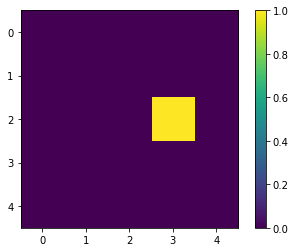

In [61]:
nx = 5
shape = np.array([nx, nx, nx])
dimensions = np.array([1, 1, 1])
radius = 1/(2*nx)
centre = np.array([0.2,0,0])
intensity = 1

v = spherical_volume(shape, dimensions, centre, radius, intensity, False)
plt.imshow(v[:,:,2]); plt.colorbar()
print(v[:,:,2])

angles = np.array([0,0,-np.pi/4])

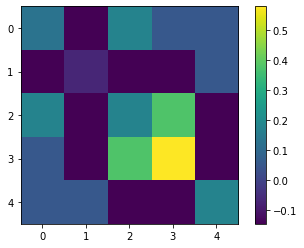

In [62]:
v_proj = project_spatial(v, angles, dimensions, "nn")

plt.imshow(v_proj); plt.colorbar()

### Step by step inside the project function

In [63]:
nx = 5
shape = np.array([nx, nx, nx])
dimensions = np.array([1, 1, 1])
radius = 1/(2*nx)
centre = np.array([0.2,0,0])
intensity = 1

v = spherical_volume(shape, dimensions, centre, radius, intensity, False)

v = np.fft.ifftshift(v)

V, X, Y, Z, _, _, _ = volume_fourier(v, dimensions)

angles = np.array([0,0,-np.pi/4])

#plt.imshow(v[:,:,0]); plt.colorbar()

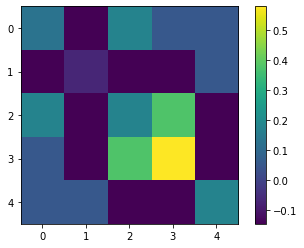

In [64]:
# Rotate coordinates

Xr, Yr, Zr = rotate(X, Y, Z, angles)
slice_coords = np.array([Xr[:,:,0].flatten(),Yr[:,:,0].flatten(),Zr[:,:,0].flatten()])

# Get x_freq, etc
x_freq = X[0,:,0]
y_freq = Y[:,0,0]
z_freq = Z[0,0,:]

# Interpolate and reshape
Vr0_flat = interpolate(slice_coords, x_freq, y_freq, z_freq, V, "nn")
Vr0 = Vr0_flat.reshape(5,5)

# Inverse Fourier transform
vr0 = np.real(np.fft.fftshift(np.fft.ifftn(Vr0)))
plt.imshow(vr0)
plt.colorbar()

In [65]:
# Compare with the above approach
np.sum(abs(vr0 - v_proj))

0.0

## Analytically

In [66]:
Ky = np.array([[0,0,0,0,0],[1,1,1,1,1],[2,2,2,2,2],[-2,-2,-2,-2,-2],[-1,-1,-1,-1,-1]])
Kx = Ky.T

In [67]:
print(Kx)

[[ 0  1  2 -2 -1]
 [ 0  1  2 -2 -1]
 [ 0  1  2 -2 -1]
 [ 0  1  2 -2 -1]
 [ 0  1  2 -2 -1]]


In [68]:
print(Ky)

[[ 0  0  0  0  0]
 [ 1  1  1  1  1]
 [ 2  2  2  2  2]
 [-2 -2 -2 -2 -2]
 [-1 -1 -1 -1 -1]]


In [69]:
# Construct Kxr and Kyr manually for -np.pi/4 rotation and NN interpolation

Kxr =np.array([[0,1,1,-1,1],
      [-1,0,1,-2,-1],
      [-1,-1,0,2,-2],
      [1,2,-2,0,1],
       [1,1,2,-1,0]])
     
Kyr = np.array([[0,1,1,-1,1],
       [1,1,2,-1,0],
       [1,2,-2,0,1],
       [-1,-1,0,2,-2],
       [-1,0,1,-2,-1]])
    
    
print(Kxr)
print(Kyr)

[[ 0  1  1 -1  1]
 [-1  0  1 -2 -1]
 [-1 -1  0  2 -2]
 [ 1  2 -2  0  1]
 [ 1  1  2 -1  0]]
[[ 0  1  1 -1  1]
 [ 1  1  2 -1  0]
 [ 1  2 -2  0  1]
 [-1 -1  0  2 -2]
 [-1  0  1 -2 -1]]


In [70]:
# Find the indices (3,2) of the point mass after ifftshift (in the spatial domain)
np.fft.ifftshift(np.arange(5))

array([2, 3, 4, 0, 1])

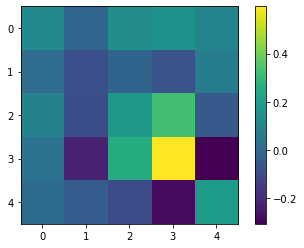

In [71]:
vr0_a = np.zeros([5,5], dtype = np.complex128)
for i in range(5):
    for j in range(5):
        vr0_a[i,j] = 1/25 * np.sum(
            np.exp(1j * 2 * np.pi/5* 
                # When ifftshifted, the indices (2, 3) become (0, 1)
                (i * Kx + j * Ky - 0 * Kxr - 1 * Kyr) 
            )
        )

vr0_a = np.real(np.fft.fftshift(vr0_a))
plt.imshow(vr0_a); plt.colorbar()

In [72]:
# Compare with the numerical result
np.sum(abs(vr0_a - vr0))

1.7497058314499205

In [73]:
Kxr.shape

(5, 5)